# Finding The MRI Dataset

Let's find the data set in this link:  https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

This is a Brain MRI Images which contains Healthy and Tumor Image
In this project I use transfer learning for classifing Healthy vs Tumor 

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

# Creat torch class

In [3]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [4]:
from torchvision.transforms import ToTensor

class MRI(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert to PIL Image for torchvision transforms
        image = torch.from_numpy(image).permute(2, 0, 1)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.float32)
        }

def load_and_preprocess_data(tumor_path, healthy_path, img_size=224):
    def process_image_folder(folder_path):
        images = []
        for f in glob.iglob(folder_path):
            img = cv2.imread(f)
            img = cv2.resize(img, (img_size, img_size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img)
        return np.array(images, dtype=np.float32)

    # Load and process images
    tumor_images = process_image_folder(tumor_path + "/*.jpg")
    healthy_images = process_image_folder(healthy_path + "/*.jpg")
    
    # Create labels
    tumor_labels = np.ones(len(tumor_images))
    healthy_labels = np.zeros(len(healthy_images))
    
    # Combine datasets
    images = np.concatenate((tumor_images, healthy_images), axis=0)
    labels = np.concatenate((tumor_labels, healthy_labels))
    
    # Normalize images
    images = images / 255.0
    
    return images, labels

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Creat a VIT model

In [6]:
def create_model(num_classes=1, freeze_base=True):
    # Get pretrained ViT
    pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    model = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
    
    # Freeze base parameters if specified
    if freeze_base:
        for param in model.parameters():
            param.requires_grad = False
    
    # Modify classifier head for binary classification
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes),
        nn.Sigmoid()
    )
    
    return model, pretrained_vit_weights.transforms()


# Train feature extractor ViT model

In [7]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in dataloader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs.squeeze(), labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    return total_loss / len(dataloader), correct / total

## Evaluate the model

In [8]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs.squeeze(), labels)
            
            total_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(dataloader), correct / total


Epoch 1/20
Train Loss: 0.6485, Train Acc: 0.6324
Test Loss: 0.6034, Test Acc: 0.7714
Epoch 2/20
Train Loss: 0.5402, Train Acc: 0.8382
Test Loss: 0.5573, Test Acc: 0.8286
Epoch 3/20
Train Loss: 0.4601, Train Acc: 0.8824
Test Loss: 0.5364, Test Acc: 0.8571
Epoch 4/20
Train Loss: 0.4017, Train Acc: 0.9191
Test Loss: 0.4687, Test Acc: 0.8571
Epoch 5/20
Train Loss: 0.3382, Train Acc: 0.9191
Test Loss: 0.4260, Test Acc: 0.8286
Epoch 6/20
Train Loss: 0.3203, Train Acc: 0.9265
Test Loss: 0.4111, Test Acc: 0.8286
Epoch 7/20
Train Loss: 0.2683, Train Acc: 0.9338
Test Loss: 0.4080, Test Acc: 0.8571
Epoch 8/20
Train Loss: 0.2591, Train Acc: 0.9485
Test Loss: 0.4132, Test Acc: 0.8857
Epoch 9/20
Train Loss: 0.2584, Train Acc: 0.9559
Test Loss: 0.4007, Test Acc: 0.8857
Epoch 10/20
Train Loss: 0.2150, Train Acc: 0.9559
Test Loss: 0.3854, Test Acc: 0.8857
Epoch 11/20
Train Loss: 0.2653, Train Acc: 0.9632
Test Loss: 0.3765, Test Acc: 0.8857
Epoch 12/20
Train Loss: 0.2129, Train Acc: 0.9632
Test Loss: 0.

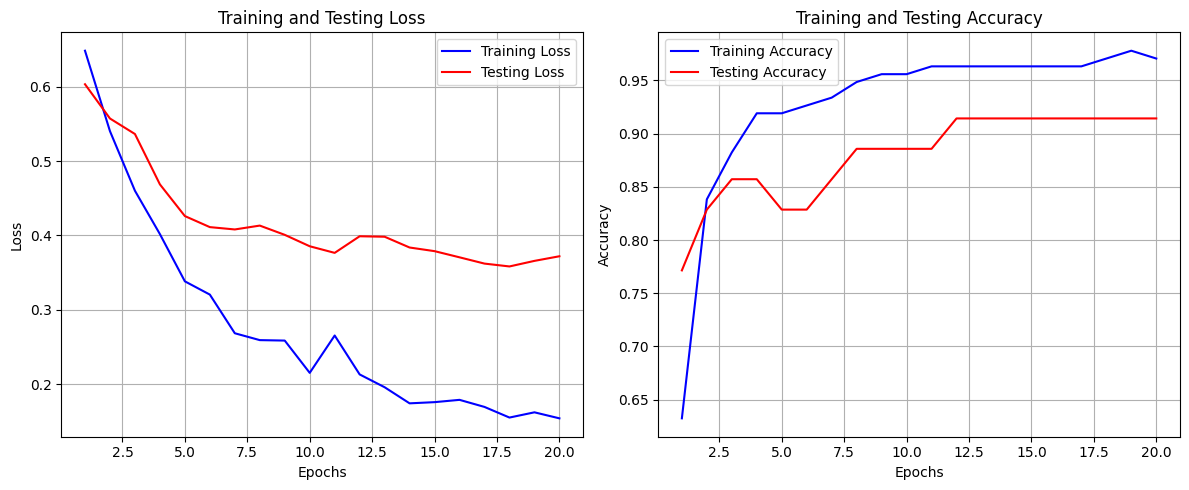

In [16]:
def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, test_accuracies, 'r-', label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

def main():
    # Set device and seeds
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(42)
    
    # Load and preprocess data
    tumor_path = "/home/narges/Downloads/archive(4)/brain_tumor_dataset/yes"
    healthy_path = "/home/narges/Downloads/archive(4)/brain_tumor_dataset/no"
    images, labels = load_and_preprocess_data(tumor_path, healthy_path)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.20, random_state=42
    )
    
    # Create model and get transforms
    model, transforms = create_model(num_classes=1, freeze_base=True)
    model = model.to(device)
    
    # Create datasets and dataloaders
    train_dataset = BrainTumorDataset(X_train, y_train, transform=transforms)
    test_dataset = BrainTumorDataset(X_test, y_test, transform=transforms)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Setup training
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCELoss()
    
    # Training loop
    num_epochs = 20
    best_accuracy = 0
    
    # Lists to store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, loss_fn, device)
        test_loss, test_acc = evaluate(model, test_dataloader, loss_fn, device)
        
        # Store metrics for plotting
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    # Plot training curves
    plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)

if __name__ == "__main__":
    main()